In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

df = pd.read_csv("./cic_ids_smote03_pca25.csv")
#df = pd.read_csv("/Users/anchanghun/Downloads/CIC-Dataset/cleaned_improved_cicids2017.csv")

In [3]:
X_train =pd.read_csv("D:/dataset/0219_Paper_Dataset/train_pca.csv")
X_test =pd.read_csv("D:/dataset/0219_Paper_Dataset/test_pca.csv")

In [4]:
X_train.shape, X_test.shape

((6378151, 26), (405464, 26))

In [5]:
y_train = X_train['label']
X_train = X_train.drop(labels='label',axis=1)

In [6]:
y_test = X_test['label']
X_test = X_test.drop(labels='label',axis=1)

In [7]:
X_train.shape, X_test.shape

((6378151, 25), (405464, 25))

In [8]:
y_train.shape, y_test.shape

((6378151,), (405464,))

In [9]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from tensorflow.keras import backend as K

# ✅ 클래스 개수 (정상 + 공격 유형 개수)
num_classes = 9  # 정상(1) + 8개 공격

# ✅ 잠재 차원 및 중간 차원 설정
latent_dim = 10
inter_dim = 20

# ✅ 샘플링 함수 (재매개변수화 트릭 사용)
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * K.clip(z_log_sigma, -10, 10)) * epsilon

# ✅ CVAE 손실 함수 (Gaussian MLP + Bernoulli MLP 반영)
def cvae_loss(x, x_decoded_mean, z_mean, z_log_sigma, y_true, y_pred):
    # Reconstruction Loss (Gaussian MLP 적용)
    reconstruction_loss = K.mean(K.square(x - x_decoded_mean) + 1e-10)  # NaN 방지
    
    # KL Divergence (잠재 공간 학습 - Gaussian MLP)
    kl_loss = -0.5 * K.sum(1 + K.clip(z_log_sigma, -10, 10) - K.square(z_mean) - K.exp(K.clip(z_log_sigma, -10, 10)), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 손실 가중치 적용

    # Classification Loss (Bernoulli MLP 적용)
    classification_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)  # 다중 분류
    
    # 총 손실 (Gaussian + Bernoulli)
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted + classification_loss)
    return total_loss

# ✅ CVAE 모델 정의 (Gaussian MLP + Bernoulli MLP)
def cvae(X, y):
    features = X.shape[1]  # 특징 수
    input_x = Input(shape=(features,), name='InputFeatures')
    input_y = Input(shape=(num_classes,), name='InputLabels')  # 라벨 추가

    # CNN 기반 인코더
    reshaped_input = layers.Reshape((features, 1))(input_x)
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Flatten()(h)
    h = layers.Concatenate()([h, input_y])  # 라벨과 결합
    h = layers.Dense(inter_dim, activation='relu')(h)

    # Gaussian MLP (잠재 공간)
    z_mean = layers.Dense(latent_dim, name='z_mean')(h)
    z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_sigma])

    # 디코더 (Gaussian MLP)
    decoder_input = layers.Concatenate()([z, input_y])  # 잠재 벡터 + 라벨
    decoder1 = layers.Dense(features * inter_dim)(decoder_input)
    decoder1 = layers.Reshape((features, inter_dim))(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Flatten()(decoder1)
    x_decoded_mean = layers.Dense(features, activation='sigmoid', name='ReconstructedOutput')(decoder1)  # 최종 복원

    # Bernoulli MLP (다중 분류)
    classification_output = layers.Dense(num_classes, activation='softmax', name='ClassificationOutput')(h)

    # 모델 생성
    model = Model([input_x, input_y], [x_decoded_mean, classification_output])
    model.add_loss(cvae_loss(input_x, x_decoded_mean, z_mean, z_log_sigma, input_y, classification_output))

    return model

# ✅ CVAE 학습 (정상 + 여러 공격 데이터 포함)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)  # 라벨 원핫 인코딩
model = cvae(X_train, y_train_onehot)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit([X_train, y_train_onehot], [X_train, y_train_onehot],  # Reconstruction + Classification
                    shuffle=True, epochs=50, validation_split=0.1, batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/50
179386/179386 [==============================] - 1316s 7ms/step - loss: 8.8306 - ReconstructedOutput_accuracy: 0.6405 - ClassificationOutput_accuracy: 0.9995 - val_loss: 0.2225 - val_ReconstructedOutput_accuracy: 0.0186 - val_ClassificationOutput_accuracy: 0.9965
Epoch 2/50
179386/179386 [==============================] - 979s 5ms/step - loss: 8.8187 - ReconstructedOutput_accuracy: 0.5949 - ClassificationOutput_accuracy: 1.0000 - val_loss: 0.2029 - val_ReconstructedOutput_accuracy: 0.1421 - val_ClassificationOutput_accuracy: 0.9999
Epoch 3/50
179386/179386 [==============================] - 827s 5ms/step - loss: 8.8179 - ReconstructedOutput_accuracy: 0.5757 - ClassificationOutput_accuracy: 1.0000 - val_loss: 0.2101 - val_ReconstructedOutput_accuracy: 0.0306 - val_ClassificationOutput_accuracy: 0.9998
Epoch 4/50
179386/179386 [==============================] - 828s 5ms/step - loss: 8.8179 - ReconstructedOutput_accuracy: 0.5465 - ClassificationOutput_accuracy: 1.0000 - val_los

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputFeatures (InputLayer)     [(None, 25)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 25, 1)        0           ['InputFeatures[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 25, 64)       256         ['reshape[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 25, 32)       6176        ['conv1d[0][0]']                 
                                                                                              

 a)                                                                                               
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 9)            0           ['InputLabels[0][0]']            
                                                                                                  
 tf.convert_to_tensor (TFOpLamb  (None, 9)           0           ['ClassificationOutput[0][0]']   
 da)                                                                                              
                                                                                                  
 tf.__oper

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 테스트 데이터 라벨 원핫 인코딩
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)



In [14]:
overlap = np.sum(np.isin(X_test, X_train).all(axis=1))
print(f"Number of overlapping samples: {overlap}")

Number of overlapping samples: 0


In [15]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (6378151, 25) Test shape: (405464, 25)


In [16]:
print("y_test unique values:", np.unique(y_test))
print("y_test_onehot shape:", y_test_onehot.shape)
print("Sample y_test_onehot:", y_test_onehot[:5])  # 일부 샘플 출력


y_test unique values: [0 1 2 3 4 5 6 7 8]
y_test_onehot shape: (405464, 9)
Sample y_test_onehot: [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
# ✅ 테스트 라벨 원-핫 인코딩 (y_test → one-hot)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

In [18]:
# ✅ 다중 분류 예측 수행
x_decoded_pred, y_pred_probs = model.predict([X_test, y_test_onehot])

# ✅ 예측된 클래스 (가장 확률이 높은 클래스 선택)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# ✅ 실제 정답 클래스
y_true_classes = np.argmax(y_test_onehot, axis=1)

# ✅ 정확도 평가
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"📊 테스트 정확도: {accuracy * 100:.2f}%")

# ✅ 상세 성능 보고서 (Precision, Recall, F1-score)
print("\n📊 분류 성능 보고서:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Normal", "Attack1", "Attack2", "Attack3", "Attack4", "Attack5", "Attack6", "Attack7", "Attack8"]))

12671/12671 [==============================] - 20s 2ms/step
📊 테스트 정확도: 99.99%

📊 분류 성능 보고서:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    318909
     Attack1       1.00      1.00      1.00     19029
     Attack2       1.00      1.00      1.00      1513
     Attack3       1.00      1.00      1.00     31694
     Attack4       0.91      1.00      0.95       348
     Attack5       1.00      1.00      1.00       772
     Attack6       1.00      1.00      1.00       794
     Attack7       1.00      1.00      1.00     31813
     Attack8       1.00      1.00      1.00       592

    accuracy                           1.00    405464
   macro avg       0.99      1.00      0.99    405464
weighted avg       1.00      1.00      1.00    405464



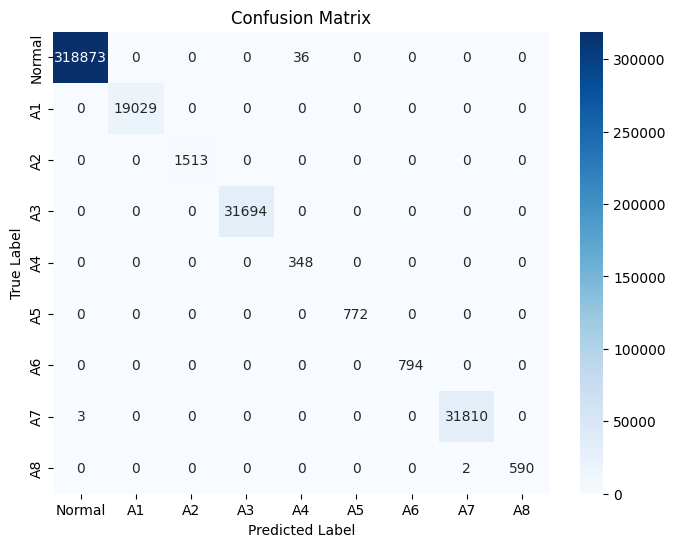

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 혼동 행렬 생성
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8"], yticklabels=["Normal", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

# One-vs-All AUC 계산
auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
print(f"📊 다중 분류 AUC Score: {auc_score:.4f}")

📊 다중 분류 AUC Score: 1.0000


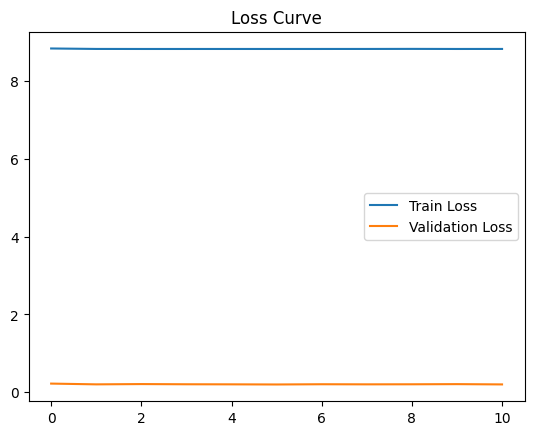

In [21]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [22]:
# y_test 없이 테스트 데이터만 사용하여 예측 수행
_, y_pred_probs = model.predict([X_test, np.zeros_like(y_test_onehot)])  # 더미 라벨 입력

# 최종 예측 클래스
y_pred_classes = np.argmax(y_pred_probs, axis=1)

12671/12671 [==============================] - 20s 2ms/step


In [23]:
# ✅ 다중 분류 예측 수행
x_decoded_pred, y_pred_probs = model.predict([X_test, y_test_onehot])

# ✅ 예측된 클래스 (가장 확률이 높은 클래스 선택)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# ✅ 실제 정답 클래스
y_true_classes = np.argmax(y_test_onehot, axis=1)

# ✅ 정확도 평가
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"📊 테스트 정확도: {accuracy * 100:.2f}%")

# ✅ 상세 성능 보고서 (Precision, Recall, F1-score)
print("\n📊 분류 성능 보고서:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Normal", "Attack1", "Attack2", "Attack3", "Attack4", "Attack5", "Attack6", "Attack7", "Attack8"]))

12671/12671 [==============================] - 20s 2ms/step
📊 테스트 정확도: 99.99%

📊 분류 성능 보고서:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    318909
     Attack1       1.00      1.00      1.00     19029
     Attack2       1.00      1.00      1.00      1513
     Attack3       1.00      1.00      1.00     31694
     Attack4       0.91      1.00      0.95       348
     Attack5       1.00      1.00      1.00       772
     Attack6       1.00      1.00      1.00       794
     Attack7       1.00      1.00      1.00     31813
     Attack8       1.00      1.00      1.00       592

    accuracy                           1.00    405464
   macro avg       0.99      1.00      0.99    405464
weighted avg       1.00      1.00      1.00    405464



In [24]:
from sklearn.metrics import roc_auc_score

# One-vs-All AUC 계산
auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
print(f"📊 다중 분류 AUC Score: {auc_score:.4f}")

📊 다중 분류 AUC Score: 1.0000


12671/12671 [==============================] - 20s 2ms/step
📊 테스트 정확도: 99.99%

📊 분류 성능 보고서:

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    318909
            DDoS       1.00      1.00      1.00     19029
   DoS GoldenEye       1.00      1.00      1.00      1513
        DoS Hulk       1.00      1.00      1.00     31694
DoS Slowhttptest       0.91      1.00      0.95       348
   DoS Slowloris       1.00      1.00      1.00       772
     FTP-Patator       1.00      1.00      1.00       794
        Portscan       1.00      1.00      1.00     31813
     SSH-Patator       1.00      1.00      1.00       592

        accuracy                           1.00    405464
       macro avg       0.99      1.00      0.99    405464
    weighted avg       1.00      1.00      1.00    405464



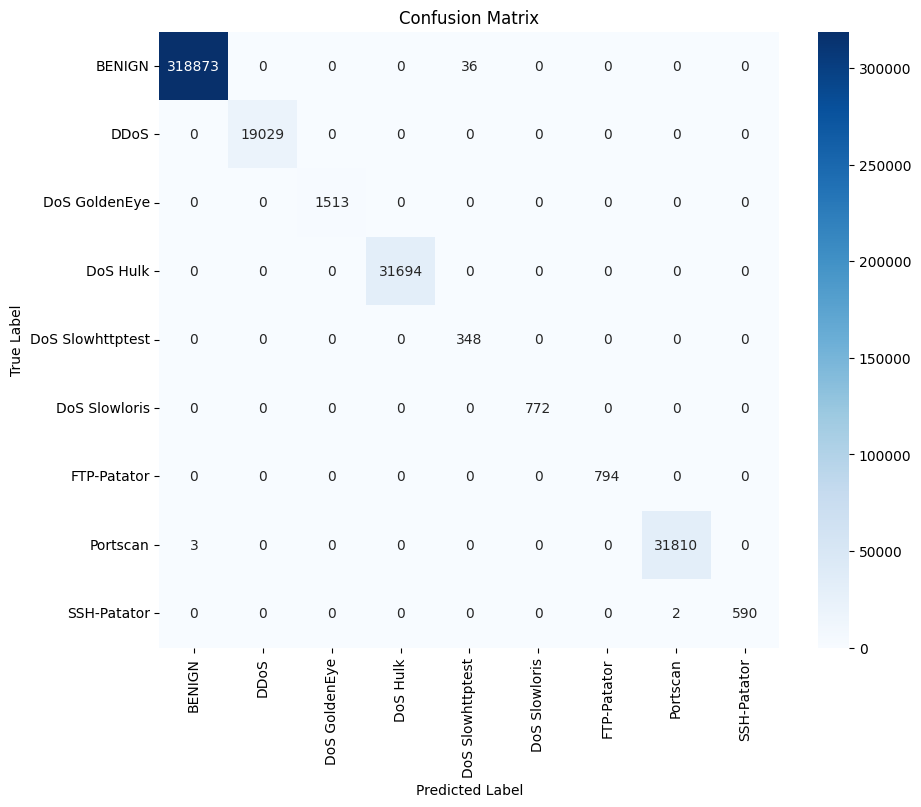

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 모델 예측
x_decoded_pred, y_pred_probs = model.predict([X_test, y_test_onehot])
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# 정확도 평가 및 상세 보고서 출력
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"📊 테스트 정확도: {accuracy * 100:.2f}%\n")

target_names = ["BENIGN", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", 
                "DoS Slowloris", "FTP-Patator", "Portscan", "SSH-Patator"]

print("📊 분류 성능 보고서:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

# Confusion Matrix 계산
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion Matrix 시각화
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
